In [73]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

In [74]:
# variable constants
L_POS = 2
L_ANGLE = 3

MLP_HIDDEN_LAYER_WIDTH = 512

BATCH_SIZE = 128
EPOCHS = 10000
PATIENCE = 0

# fixed constants
SH_FLOAT_COUNT = 27

PROBES_DIM_X = 50
PROBES_DIM_Y = 5
PROBES_DIM_Z = 5
PROBES_COUNT = PROBES_DIM_X * PROBES_DIM_Y * PROBES_DIM_Z

ENCODED_POS_DIM = 3 * L_POS * 2
ENCODED_ANGLE_DIM = 1 * L_ANGLE * 2

INPUT_DIM = PROBES_COUNT + ENCODED_POS_DIM + ENCODED_ANGLE_DIM

In [75]:
class NeuralSH(nn.Module):
    def __init__(self):
        super(NeuralSH, self).__init__()
        self.probe_features = nn.Parameter(torch.rand(PROBES_COUNT), requires_grad=True)

        self.hidden_layer = nn.Linear(INPUT_DIM, MLP_HIDDEN_LAYER_WIDTH)
        self.hidden_layer2 = nn.Linear(MLP_HIDDEN_LAYER_WIDTH, MLP_HIDDEN_LAYER_WIDTH)
        self.hidden_layer3 = nn.Linear(MLP_HIDDEN_LAYER_WIDTH, MLP_HIDDEN_LAYER_WIDTH)

        self.output_layer = nn.Linear(MLP_HIDDEN_LAYER_WIDTH, SH_FLOAT_COUNT)

    def trigonometric_encoding(self, x: torch.Tensor, L: int):
        assert x.ndim == 2
        y = []
        for i in range(L):
            s = torch.sin(2**i * torch.pi * x)
            c = torch.cos(2**i * torch.pi * x)
            y.append(s)
            y.append(c)
        y = torch.cat(y, dim=1)
        return y

    def forward(self, pos, angle):
        assert pos.ndim == 2
        assert angle.ndim == 2

        pos = pos.view(-1, 3)
        angle = angle.view(-1, 1)

        assert pos.shape[0] == angle.shape[0]
        batch_size = pos.shape[0]

        pos_enc = self.trigonometric_encoding(pos, L=L_POS)
        angle_enc = self.trigonometric_encoding(angle, L=L_ANGLE)

        x = torch.cat([pos_enc, angle_enc, self.probe_features.repeat(batch_size, 1)], dim=1)
        x = torch.sigmoid(self.hidden_layer(x))
        x = torch.sigmoid(self.hidden_layer2(x))
        x = torch.sigmoid(self.hidden_layer3(x))
        x = self.output_layer(x)
        return x


In [76]:
xx, yy, zz = np.meshgrid(
    np.linspace(0.0 + 1/(2*PROBES_DIM_X), 1.0 - 1/(2*PROBES_DIM_X), PROBES_DIM_X),
    np.linspace(0.0 + 1/(2*PROBES_DIM_Y), 1.0 - 1/(2*PROBES_DIM_Y), PROBES_DIM_Y),
    np.linspace(0.0 + 1/(2*PROBES_DIM_Z), 1.0 - 1/(2*PROBES_DIM_Z), PROBES_DIM_Z),
    indexing="ij"
)
pos_grid = np.stack([xx, yy, zz], axis=-1).reshape(-1, 3, order="F") # ensures texture-like (x=fastest, y=middle, z=slowest) ordering
pos_grid.shape

(1250, 3)

In [77]:
pos_grid

array([[0.01, 0.1 , 0.1 ],
       [0.03, 0.1 , 0.1 ],
       [0.05, 0.1 , 0.1 ],
       ...,
       [0.95, 0.9 , 0.9 ],
       [0.97, 0.9 , 0.9 ],
       [0.99, 0.9 , 0.9 ]], shape=(1250, 3))

In [78]:
light_angle = np.zeros((pos_grid.shape[0], 1), dtype=float)
light_angle.shape

(1250, 1)

In [79]:
from dataclasses import dataclass, fields
from pathlib import Path

from texture_sampler import Texture, load_texture_by_name, sample_uv

DATA_DIR = Path("LightmapsData/")

@dataclass
class SHTextures:
    AmbientVector: Texture

    SHCoefficients0Red: Texture
    SHCoefficients0Green: Texture
    SHCoefficients0Blue: Texture

    SHCoefficients1Red: Texture
    SHCoefficients1Green: Texture
    SHCoefficients1Blue: Texture

def LoadTextures():
    return SHTextures(
        AmbientVector=load_texture_by_name(DATA_DIR, "AmbientVector"),

        SHCoefficients0Red=load_texture_by_name(DATA_DIR, "SHCoefficients_0"),
        SHCoefficients0Green=load_texture_by_name(DATA_DIR, "SHCoefficients_2"),
        SHCoefficients0Blue=load_texture_by_name(DATA_DIR, "SHCoefficients_4"),

        SHCoefficients1Red=load_texture_by_name(DATA_DIR, "SHCoefficients_1"),
        SHCoefficients1Green=load_texture_by_name(DATA_DIR, "SHCoefficients_3"),
        SHCoefficients1Blue=load_texture_by_name(DATA_DIR, "SHCoefficients_5"),
    )

def Texture3DSample(tex: Texture, uvw: np.ndarray, method: str = "nearest"):
    uvw = uvw.reshape(-1, 3)
    _, _, _, channels = tex.data.shape
    results = []
    for p in uvw:
        color = sample_uv(tex, p[0], p[1], p[2], method=method)
        color = color.reshape(-1, channels)
        results.append(color)
    results = np.concatenate(results, axis=0)
    return results

def GetRawSH3(BrickTextureUVs: np.ndarray):
    tex = LoadTextures()

    AmbientVector = Texture3DSample(tex.AmbientVector, BrickTextureUVs)

    SHCoefficients0Red = Texture3DSample(tex.SHCoefficients0Red, BrickTextureUVs)
    SHCoefficients0Green = Texture3DSample(tex.SHCoefficients0Green, BrickTextureUVs)
    SHCoefficients0Blue = Texture3DSample(tex.SHCoefficients0Blue, BrickTextureUVs)

    SHCoefficients1Red = Texture3DSample(tex.SHCoefficients1Red, BrickTextureUVs)
    SHCoefficients1Green = Texture3DSample(tex.SHCoefficients1Green, BrickTextureUVs)
    SHCoefficients1Blue = Texture3DSample(tex.SHCoefficients1Blue, BrickTextureUVs)

    IrradianceSH = np.concatenate([
        AmbientVector[:, 0:1], # .x
        SHCoefficients0Red[:],
        SHCoefficients1Red[:],
        AmbientVector[:, 1:2], # .y
        SHCoefficients0Green[:],
        SHCoefficients1Green[:],
        AmbientVector[:, 2:3], # .z
        SHCoefficients0Blue[:],
        SHCoefficients1Blue[:],
    ], axis=1)

    return IrradianceSH

def SH3ToTex(sh: np.ndarray):
    assert sh.ndim == 2
    assert sh.shape[1] == 27

    textures = LoadTextures()

    textures.AmbientVector.data = np.concatenate([sh[:, 0:1], sh[:, 9:10], sh[:, 18:19]], axis=1)
    textures.SHCoefficients0Red.data = sh[:, 1:5]
    textures.SHCoefficients1Red.data = sh[:, 5:9]
    textures.SHCoefficients0Green.data = sh[:, 10:14]
    textures.SHCoefficients1Green.data = sh[:, 14:18]
    textures.SHCoefficients0Blue.data = sh[:, 19:23]
    textures.SHCoefficients1Blue.data = sh[:, 23:27]

    for field in fields(SHTextures):
        tex = getattr(textures, field.name)
        # this assumes correct texture-like ordering of tex.data,
        # where width changes the fastest, then height and depth is the slowest
        tex.data = tex.data.reshape(
            tex.meta.depth, tex.meta.height, tex.meta.width, -1
        )

    return textures


In [80]:
true_sh = GetRawSH3(pos_grid)
true_sh.shape

(1250, 27)

# Training

In [81]:
from torch.utils.data import Dataset, DataLoader, random_split

class SHDataset(Dataset):
    def __init__(
            self,
            positions_data: np.ndarray,
            light_angles_data: np.ndarray,
            spherical_harmonics_data: np.ndarray
        ):
        super().__init__()
        self.positions_data = torch.FloatTensor(positions_data)
        self.light_angles_data = torch.FloatTensor(light_angles_data)
        self.spherical_harmonics_data = torch.FloatTensor(spherical_harmonics_data)
        assert spherical_harmonics_data.shape[1] == SH_FLOAT_COUNT

    def __getitem__(self, index):
        source = self.positions_data[index], self.light_angles_data[index]
        target = self.spherical_harmonics_data[index]
        return source, target

    def __len__(self):
        assert len(self.positions_data) == len(self.light_angles_data)
        return len(self.positions_data)

In [82]:
dataset = SHDataset(pos_grid, light_angle, true_sh)
# train_ds, test_ds = random_split(dataset, [1.0, 0.0], torch.Generator().manual_seed(42))

# train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
# test_dl = DataLoader(test_ds, batch_size=len(test_ds))

train_ds = dataset
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

In [83]:
def train(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
          epochs=100, lr=1e-3, patience=10, device="cuda"):
    model = model.to(device)
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    epochs_no_improve = 0
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        for source, target in train_loader:
            pos, angle = source
            pos = pos.to(device)
            angle = angle.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            outputs = model(pos, angle)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)

        # Validation
        avg_val_loss = np.nan
        if val_loader:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for source, target in val_loader:
                    pos, angle = source
                    pos = pos.to(device)
                    angle = angle.to(device)
                    target = target.to(device)
                    outputs = model(pos, angle)
                    val_loss = criterion(outputs, target)
                    val_losses.append(val_loss.item())

            avg_val_loss = np.mean(val_losses)

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {avg_train_loss:.6f} "
              f"Val Loss: {avg_val_loss:.6f}")

        if (patience != 0) and val_loader: # early stopping based on validation loss
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                epochs_no_improve = 0
                torch.save(model.state_dict(), "best_model.pth")
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"Early stopping triggered after {epoch+1} epochs.")
                    model.load_state_dict(torch.load("best_model.pth"))
                    break

    if (patience == 0) or (val_loader is None): # save model every epoch
        torch.save(model.state_dict(), "best_model.pth")

    return model, history


In [ ]:
# model = NeuralSH()

In [ ]:
# model, history = train(
#     model,
#     train_loader=train_dl,
#     val_loader=None,
#     epochs=EPOCHS,
#     patience=PATIENCE
# )

Epoch [1/10000] Train Loss: 0.064900 Val Loss: nan
Epoch [2/10000] Train Loss: 0.034060 Val Loss: nan
Epoch [3/10000] Train Loss: 0.030026 Val Loss: nan
Epoch [4/10000] Train Loss: 0.028579 Val Loss: nan
Epoch [5/10000] Train Loss: 0.028334 Val Loss: nan
Epoch [6/10000] Train Loss: 0.027948 Val Loss: nan
Epoch [7/10000] Train Loss: 0.027732 Val Loss: nan
Epoch [8/10000] Train Loss: 0.027865 Val Loss: nan
Epoch [9/10000] Train Loss: 0.027787 Val Loss: nan
Epoch [10/10000] Train Loss: 0.027875 Val Loss: nan
Epoch [11/10000] Train Loss: 0.027706 Val Loss: nan
Epoch [12/10000] Train Loss: 0.027650 Val Loss: nan
Epoch [13/10000] Train Loss: 0.027770 Val Loss: nan
Epoch [14/10000] Train Loss: 0.027663 Val Loss: nan
Epoch [15/10000] Train Loss: 0.027525 Val Loss: nan
Epoch [16/10000] Train Loss: 0.027922 Val Loss: nan
Epoch [17/10000] Train Loss: 0.028114 Val Loss: nan
Epoch [18/10000] Train Loss: 0.027800 Val Loss: nan
Epoch [19/10000] Train Loss: 0.027806 Val Loss: nan
Epoch [20/10000] Trai

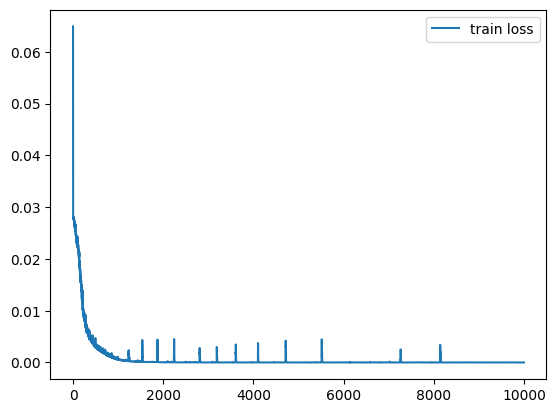

In [86]:
plt.plot(history["train_loss"], label="train loss")
plt.legend()
plt.show()

# Compare with textures

In [87]:
model = NeuralSH()
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [88]:
true_sh = true_sh
with torch.no_grad():
    pred_sh = model(torch.tensor(pos_grid, dtype=torch.float32), torch.tensor(light_angle, dtype=torch.float32))
pred_sh = pred_sh.numpy()
assert true_sh.shape == pred_sh.shape

In [89]:
true_sh_tex = SH3ToTex(true_sh)
pred_sh_tex = SH3ToTex(pred_sh)

In [90]:
# verify that nearest sampling yields the same result as loading a raw texture
raw_sh_tex = LoadTextures()
for field in fields(SHTextures):
    raw = getattr(raw_sh_tex, field.name).data
    true = getattr(true_sh_tex, field.name).data
    assert np.all(raw == true)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0033960417..4.4410677].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.4375].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0033504143..9.0027685].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..9.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0039718..1.5586581].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.002643548..2.8744562].
Clipping i

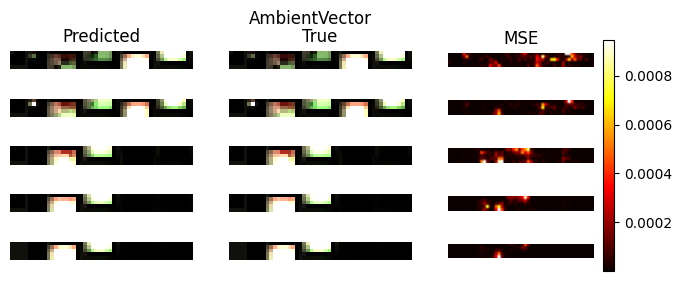

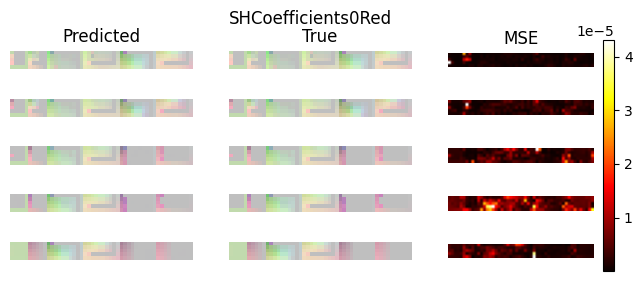

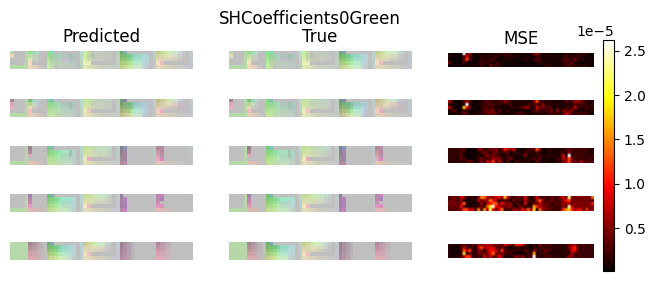

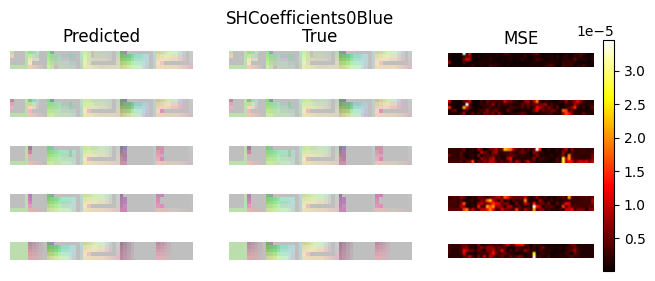

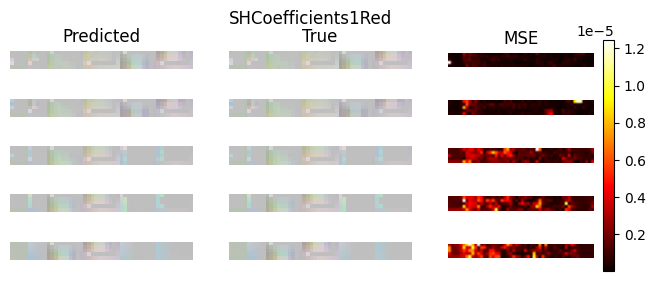

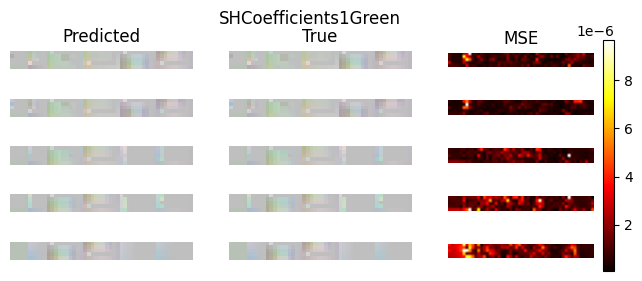

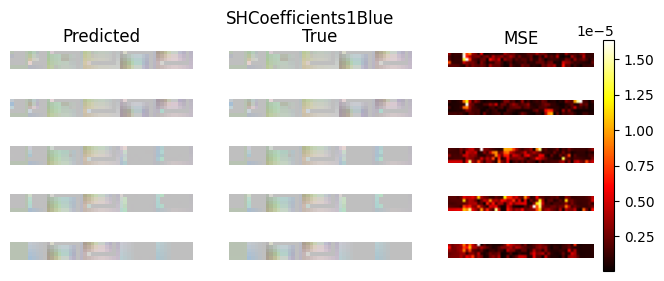

In [93]:
for field in fields(SHTextures):
    pred = getattr(pred_sh_tex, field.name).data
    true = getattr(true_sh_tex, field.name).data
    mse = np.mean((true - pred) ** 2, axis=-1)

    fig, axes = plt.subplots(5, 3, figsize=(8, 3))

    # Column titles
    column_titles = ["Predicted", "True", "MSE"]
    for col, title in enumerate(column_titles):
        axes[0, col].set_title(title, fontsize=12)

    # Plot images
    for row in range(5):
        for col in range(3):
            axes[row, col].axis("off")

        axes[row, 0].imshow(pred[row])
        axes[row, 1].imshow(true[row])
        im = axes[row, 2].imshow(mse[row], cmap='hot')  # Save handle for colorbar

    # Add colorbar for the last MSE image
    cbar = fig.colorbar(im, ax=axes[:, 2])

    fig.suptitle(f"{field.name}")
    fig.savefig(f"img/{field.name}.png")
